<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/preprocessing/DF_to_UVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hier wird mit Hilfe der vorverarebiteten Messdaten der UVI berechnet:

**Dokumentenname: DF_to_UVI.ipynb**

Es werden die vorverarbeiteten UV-Spektren in einen UVI und in die UVA und UVB Strahlung aggregiert. Zu Beginn muss das Skript *UV_Measurement_to_CSV* ausgeführt werden, um die Spektren in einen Dataframe umzuwandeln. Aufgrund der großen Datenmenge geschieht die Verarbeitung für jeden Monat getrennt.

## Import der benötigten Module:

In [1]:
# Import der benötigten Module
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mount der Google-Drive:

In [2]:
# Mount google drive
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Monat der Exportiert werden sollen:**

22.06
22.07
22.08
22.09
22.10
22.11
22.12
23.01
23.02
23.03
23.04
23.05
(Keine Messdaten für 23.06)
23.07
23.08

In [3]:
month = '23.01'

## Daten einlesen:

In [4]:
# Import der CSV mit den rohen Messdaten
# Pfad zur CSV-Datei auf Google Drive
# Import:
folder_import = '/content/drive/My Drive/Colab_Notebooks/CSV_Messdaten/' + month

# Export:
folder_export = '/content/drive/My Drive/Colab_Notebooks/CSV_UVI'
folder_export_Gewichtet = '/content/drive/My Drive/Colab_Notebooks/CSV_Gewichtet'

# CSV-Datei einlesen und DataFrame erstellen
df_Messdaten = pd.read_csv(folder_import)

## Definetion der UV-Gewichtungsfunktion und UVA und UVB Bereich:

In [5]:
# Gewichtungsfunktion für den UVI
def weight_function(Wellenlaenge):
    if Wellenlaenge <= 298:
        return 1
    elif Wellenlaenge > 298 and Wellenlaenge <= 328:
        return 10**(0.094 * (298.0 - Wellenlaenge))
    elif Wellenlaenge > 328 and Wellenlaenge <= 400:
        return 10**(0.015 * (139.0 - Wellenlaenge))
    else:
        return 0

In [6]:
# Bereich von Spalte x bis Spalte y (einschließlich y)
x_UVI = '290.0'
y_UVI = '400.0'
selected_columns_UVI = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVI)):(df_Messdaten.columns.get_loc(y_UVI)+1)]

In [7]:
# UVB Bereich von 290 bis 320.1 nm
x_UVB = '290.0'
y_UVB = '315.0'
selected_columns_UVA = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVB)):(df_Messdaten.columns.get_loc(y_UVB)+1)]

In [8]:
# UVA Bereich von 320.1 bis 400 nm
x_UVA = '315.1'
y_UVA = '400.0'
selected_columns_UVB = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVA)):(df_Messdaten.columns.get_loc(y_UVA)+1)]

## Erythemgewichtete UV-Messwerte, UVI und UVA UVB bestimmen:

In [9]:
# Erythemgewichtete UV-Messwerte
df_Gewichtet = []
df_Gewichtet = df_Messdaten[selected_columns_UVI].apply(lambda col: col * weight_function(float(col.name)), axis=0)

In [10]:
def integrate_row(row):
    x_values = np.array([float(col) for col in row.index])  # X-Werte aus Spaltennamen extrahieren
    y_values = np.array(row)
    integral = np.trapz(y_values, x_values)
    return integral

In [11]:
def calculate_UV_ABC(df):
    return df.sum(axis=1)

In [12]:
# Summe der Messwerte über das UVA und UVB Spektrum
UVA = calculate_UV_ABC(df_Messdaten[selected_columns_UVA])
UVB = calculate_UV_ABC(df_Messdaten[selected_columns_UVB])
# Spalte umbenennen
UVA.name = 'UVA'
UVB.name = 'UVB'

In [13]:
ser_UVI = []
df_UVI = []

# Integration der gewichteten UV-Messwerte
ser_UVI = df_Gewichtet.apply(integrate_row, axis=1)
# Umwandeln der Serie in einen Dataframe
df_UVI = pd.DataFrame(ser_UVI, columns=['erythem'])

<ipython-input-10-21a93dca7bae>:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y_values, x_values)


In [14]:
# Dem Dataframe die Werte für UVA und UVB hinzufügen
df_UV = pd.concat([df_UVI, UVA, UVB], axis=1)

In [15]:
type(df_Gewichtet), type(df_UV)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Abspeichern der UVI, UVA, UVB Messwerte in einen Dataframe:

In [16]:
# Exportieren

columns_to_copy = ['Datetime', 'Datum', 'Uhrzeit', 'Messzeitpunkt']

for col in columns_to_copy:
  df_Gewichtet.insert(0, col, df_Messdaten[col])
  df_UV.insert(0, col, df_Messdaten[col])
  df_UV['UVI'] = df_UV['erythem'].copy() * 40

In [17]:
# Ändern der Reihenfolge der Spalten
# Aktuelle Spaltennamen
new_columns = ['Datetime','UVI','UVA','UVB','erythem','Datum','Uhrzeit','Messzeitpunkt']
df_UV = df_UV[new_columns]

In [18]:
df_UV

,Datetime,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt
0,2023-01-03 13:23:00,0.332390,0.371228,85.356765,0.008310,2023-01-03,13:23:00,48180
1,2023-01-03 13:25:00,0.322621,0.355891,83.298211,0.008066,2023-01-03,13:25:00,48300
2,2023-01-03 13:27:00,0.310985,0.341128,79.773881,0.007775,2023-01-03,13:27:00,48420
3,2023-01-03 13:29:00,0.304404,0.322217,82.499323,0.007610,2023-01-03,13:29:00,48540
4,2023-01-03 13:31:00,0.302564,0.318067,82.377771,0.007564,2023-01-03,13:31:00,48660
...,...,...,...,...,...,...,...,...
7390,2023-01-31 15:56:00,0.010694,0.008321,3.308028,0.000267,2023-01-31,15:56:00,57360
7391,2023-01-31 15:58:00,0.007971,0.006026,2.420866,0.000199,2023-01-31,15:58:00,57480
7392,2023-01-31 16:00:00,0.007300,0.005738,2.222130,0.000182,2023-01-31,16:00:00,57600
7393,2023-01-31 16:02:00,0.006579,0.005184,2.003991,0.000164,2023-01-31,16:02:00,57720


In [19]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

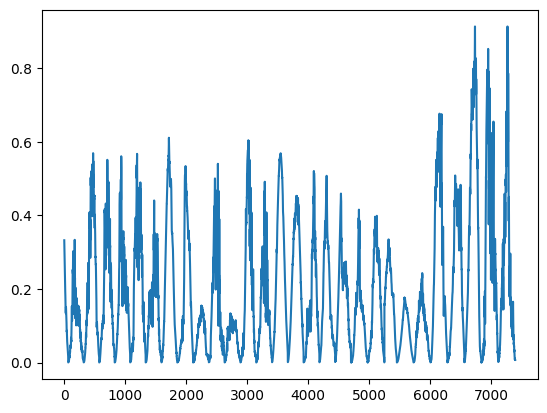

In [20]:
plt.plot(df_UV['UVI'])

In [21]:
df_UV[df_UV['Datum'].astype('string') == '2023-05-26']

,Datetime,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt


In [22]:
df_UV.describe()

,UVI,UVA,UVB,erythem,Messzeitpunkt
count,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,0.198086,0.272001,42.135608,0.004952,41159.772819
std,0.175075,0.292232,33.436071,0.004377,9157.773639
min,0.000072,0.000000,0.030312,0.000002,24600.000000
25%,0.054563,0.042390,15.603432,0.001364,33300.000000
50%,0.144650,0.175907,33.523925,0.003616,41220.000000
75%,0.306833,0.410477,64.056565,0.007671,49140.000000
max,0.913701,1.717659,146.520064,0.022843,57840.000000


In [23]:
# save_dataframe_to_drive(df_UV, folder_export, month)

In [24]:
# save_dataframe_to_drive(df_Gewichtet, folder_export_Gewichtet, month)